# Mapping drought indicator

> NOTE: no longer aim to calculate person exposures by pixel


A simple accepted measure for drought is the Standardized Precipitation Index (SPI). Similar to indicators 1.1 and 1.2, this indicator is not a direct measure of health impacts of drought, but rather a measure of the risk factor, which is mediated by a range of complicated causes to health. In general, the claim is that increase in this indicator represents an increased risk, which may lead directly to negative impacts on health or require adaptation measures to mitigate negative impacts.



| SPI  A+S   | SPI Agnew| Category         |
|------------|----------|------------------|
|  >-0.99    | >= -0.84 | Normal           | 
| -1.5 to -1 | < -0.84  | Moderate Drought |
| -1.5 to -2 | < -1.28  | Severe drought   | 
| < -2       | < -1.65  | Extreme drought  |



Select the locations experiencing 'Severe' drought. Define the drought indicator as 'number of months in drought' for a given year.

> NOTE use the -1.5 threshold since it was defined by WMO 2012 document


## Literature on selection of drought index

In 2009, the World Meteorological Organization (WMO) approved the Lincoln Declaration on Drought Indices (LDDI). The LDDI recommends that "the Standardized Precipitation Index (SPI) be used to characterize the meteorological droughts around the world", in addition to other drought indices that were in use in their service. In support of this recommendation, it was suggested that a "comprehensive user manual" describing the SPI should be developed. The manual provides a description of the index, the computation methods, specific examples of where it is currently being used, the strengths and limitations and mapping capabilities.

https://www.ncl.ucar.edu/Applications/spi.shtml

https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi


Note this one also good for extreme rain

https://link.springer.com/chapter/10.1007/978-94-015-9265-9_2

## SPI drought index

Python code:

https://www.drought.gov/drought/python-climate-indices


## Data for SPI

Monthly summary data for PPT from ERA interim

Use PPT data from CRU https://crudata.uea.ac.uk/cru/data/hrg/ http://data.ceda.ac.uk//badc/cru/data/cru_ts/cru_ts_4.01/data/ which covers a much longer time period than ECMFW ERA Interim (but only at monthly scale, which is not enough for heatwaves and i think labour).

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from scipy import stats

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [3]:
import hvplot.xarray

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = (5, 2.7)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'

In [5]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

#CRU data is one year behind ERA5
MAX_YEAR = 2018

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'

RESULTS_FOLDER = Path('./results/drought')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'drought'/ 'results_2020'
INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

# 'Severity X or worse'
MODERATE_DROUGHT_THRESHOLD = -1
SEVERE_DROUGHT_THRESHOLD = -1.5
EXTREME_DROUGHT_THRESHOLD = -2

SPI3_INPUT_FILE = DATA_SRC / 'lancet' / 'spi_calculations' / f'spi3_cru_ts4.03_1901_{MAX_YEAR}_cru.nc'
SPI6_INPUT_FILE = DATA_SRC / 'lancet' / 'spi_calculations' / f'spi6_cru_ts4.03_1901_{MAX_YEAR}_cru.nc'
SPI12_INPUT_FILE = DATA_SRC / 'lancet' / 'spi_calculations' / f'spi12_cru_ts4.03_1901_{MAX_YEAR}_cru.nc'

SPI_PROJ_OUT = DATA_SRC / 'lancet' / 'spi_calculations' / 'spi6_projected'
SPI_PROJ_OUT.mkdir(exist_ok=True)

In [6]:
MAP_PROJECTION = ccrs.EckertIII()

# TODO need to get a land mask that matches the coord system of the CRU data

In [7]:
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [8]:
land_mask = (COUNTRIES_RASTER.country_codes < 9999)

In [9]:
def plot_events_map(plot_data, ax=None):
    plot_data = plot_data.where(plot_data > 0)
    plot_data.name = 'N droughts'

    if ax is None:
        f, ax = plt.subplots(subplot_kw=dict(projection=MAP_PROJECTION), constrained_layout=True)
    
    plot_data.plot.pcolormesh(
        cmap='plasma',
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal','label':''},
        ax=ax
    )
    ax.coastlines()
    return ax

# Load SPI data

In [10]:
spi3 = xr.open_dataarray(SPI3_INPUT_FILE,
                         chunks={'time': 12}
                        )

In [11]:
spi6 = xr.open_dataarray(SPI6_INPUT_FILE,
                         chunks={'time': 12}
                        )

In [12]:
spi12 = xr.open_dataarray(SPI12_INPUT_FILE,
                         chunks={'time': 12}
                        )

In [13]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(spi6.lat))

# Calculate the number of months where the SPI dropped below the threshold for drought

- Consider the incidences of 'Severe' drought (SPI< -1.5) and 'Extreme' drought (SPI < -2)


In [14]:
def calc_droughs(spi):
    drought_counts = xr.concat(
        [(spi < MODERATE_DROUGHT_THRESHOLD),
         (spi < SEVERE_DROUGHT_THRESHOLD),
         (spi < EXTREME_DROUGHT_THRESHOLD)],
        dim=pd.Index([MODERATE_DROUGHT_THRESHOLD,SEVERE_DROUGHT_THRESHOLD,EXTREME_DROUGHT_THRESHOLD], name='spi_threshold')
    )
    drought_counts = (drought_counts
                      .groupby('time.year')
                      .sum(dim='time')
                      .astype(np.float32)
                      .compute()
                      .rename({'lat': 'latitude', 'lon': 'longitude'})
                      .assign_coords(drought_severity=('spi_threshold', ['MODERATE_DROUGHT','SEVERE_DROUGHT','EXTREME_DROUGHT']))
                     )
    drought_counts.name = 'N droughts'
    return drought_counts

## Apply to SPI3

In [15]:
drought_counts3 = calc_droughs(spi3)

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


## Apply to SPI6 

In [16]:
drought_counts6 = calc_droughs(spi6)

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


## Apply to SPI12

In [17]:
drought_counts12 = calc_droughs(spi12)

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


## Merge

In [18]:
drought_counts = xr.merge([drought_counts12.expand_dims({'spi_months': [12]}), 
                           drought_counts6.expand_dims({'spi_months': [6]}),
                           drought_counts3.expand_dims({'spi_months': [3]})
                          ])

In [19]:
mask = np.isfinite(spi6.isel(time=10, drop=True)).rename({'lat': 'latitude', 'lon': 'longitude'}).load()
drought_counts = drought_counts.where(mask)

In [20]:
drought_counts = drought_counts.reindex(latitude=list(reversed(drought_counts.latitude)))

In [22]:
drought_counts

<xarray.Dataset>
Dimensions:           (latitude: 360, longitude: 720, spi_months: 3, spi_threshold: 3, year: 118)
Coordinates:
  * latitude          (latitude) float64 89.75 89.25 88.75 ... -89.25 -89.75
  * spi_months        (spi_months) int64 3 6 12
  * longitude         (longitude) float32 -179.75 -179.25 ... 179.25 179.75
  * spi_threshold     (spi_threshold) float64 -1.0 -1.5 -2.0
  * year              (year) int64 1901 1902 1903 1904 ... 2015 2016 2017 2018
    drought_severity  (spi_threshold) <U16 'MODERATE_DROUGHT' ... 'EXTREME_DROUGHT'
Data variables:
    N droughts        (spi_months, spi_threshold, latitude, longitude, year) float32 nan ... nan

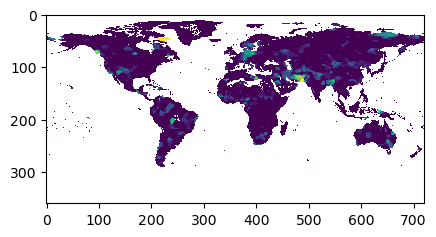

In [23]:
# Double check the underlying data orientation is correct by comparing the
# XR plot with the raw data plot
plt.imshow(drought_counts['N droughts'].isel(year=-1, spi_threshold=1, spi_months=1).data)

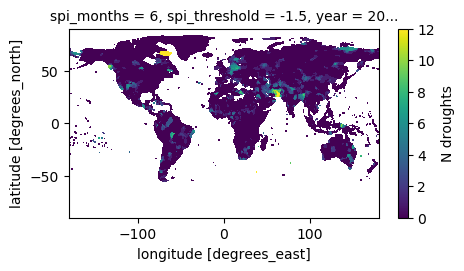

In [24]:
drought_counts['N droughts'].isel(year=-1, spi_threshold=1, spi_months=1).plot()

In [21]:
# # Calculate grid cell areas
# delta_lon = spi6.lon[1] - spi6.lon[0]
# earth_radius = 6371

# areas = (np.sin(np.radians(spi6.lat.values + 0.25))
#  - np.sin(np.radians(spi6.lat.values - 0.25))) * (np.radians(delta_lon.values)) * earth_radius**2

from util import area_of_pixel

areas = area_of_pixel(0.5, drought_counts.latitude.values) / (1000*1000)
areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': drought_counts6.latitude})

In [22]:
# Calculate total earth surface area using same pixel definition
total_earth_area = len(drought_counts.longitude) * areas.sum()

In [23]:
total_land_area = (mask * areas).sum()

In [24]:
total_land_area

<xarray.DataArray ()>
array(1.43950108e+08)

In [25]:
# Its a bit off :/
(total_land_area / total_earth_area).item()

0.28221879986931814

## Map plot combined drought counts

> Select just a few years for example

In [1]:
# Manually select a few years since 1901 to plot
years = [1901, 1950, 1980, 1986, 2000, 2005, 2010, MAX_YEAR]

(drought_counts.sel(year=years, spi_threshold=[SEVERE_DROUGHT_THRESHOLD, EXTREME_DROUGHT_THRESHOLD])
 .hvplot(
    'longitude', 'latitude', 
    projection=MAP_PROJECTION, coastline=True,
    project=True, global_extent=True, 
    cmap='plasma', 
#     rasterize=True, 
    dynamic=True, 
    frame_width=500,
#     levels=12,
#     clim=(0,12)
))

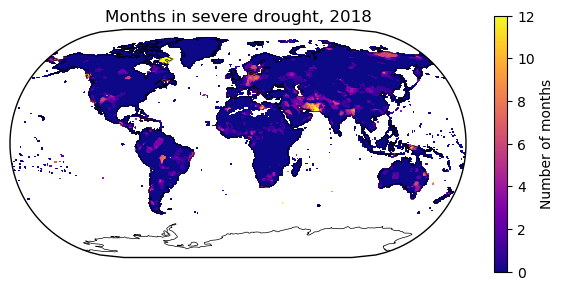

In [81]:
f = plt.figure(figsize=(6,3))

plot_data = drought_counts['N droughts'].sel(year=2018,spi_threshold=SEVERE_DROUGHT_THRESHOLD, spi_months=6)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
#     add_colorbar=False,
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=12
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Months in severe drought, {MAX_YEAR}')
plt.tight_layout()

f.savefig(RESULTS_FOLDER/ f'map_severe_drought_count_{MAX_YEAR}')
f.show()


# Calculate Mean and SD of droughts during baseline period and plot relative to this

The idea is that we care about events that are more unusual also relative to the typical variation. So if we consider the 'normal' spread of drought events during the reference period, then we want to see what areas are in the extreme ranges of this.


In [28]:
# drought_counts_mean = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year').compute()
# drought_counts_std = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).std(dim='year').compute()

In [26]:
drought_counts_mean = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year').compute()
drought_counts_std = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).std(dim='year').compute()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [30]:
# (drought_counts_mean.hvplot.contourf(
#     'longitude', 'latitude', projection=MAP_PROJECTION, project=True, global_extent=True, 
#     cmap='plasma', rasterize=False, dynamic=True, coastline=True, 
#     frame_width=380
# ) 
#  + drought_counts_std.hvplot.contourf(
#     'longitude', 'latitude', projection=MAP_PROJECTION, project=True, global_extent=True, 
#     cmap='plasma', rasterize=False, dynamic=True, coastline=True, 
#     frame_width=380
#  ))

## Plot events where the count is over 2 SD above the mean

> Showing only data every few years to avoid overloading the browser

In [27]:
drought_over_2std = (drought_counts > (drought_counts_mean + 2*drought_counts_std)).astype(int)
drought_over_2std = drought_over_2std.where(mask)

In [2]:
# Select few years otherwise chokes up HvPlot
years = list(range(1980, MAX_YEAR+1, 10))a
years.append(MAX_YEAR)

drought_over_2std.sel(year=years,spi_threshold=[SEVERE_DROUGHT_THRESHOLD, EXTREME_DROUGHT_THRESHOLD]).hvplot.contourf(
    'longitude', 'latitude', 
    projection=MAP_PROJECTION, 
    project=True, global_extent=True, 
    cmap='Reds',
#     rasterize=True, 
    dynamic=False, 
    coastline=True, 
    frame_width=500)

In [32]:
import matplotlib.colors as colors

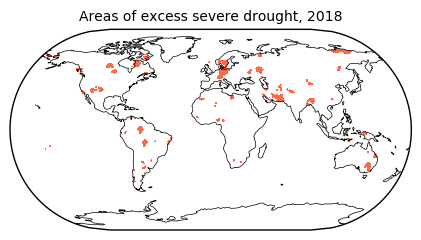

In [36]:

plot_data = drought_over_2std['N droughts'].sel(year=2018,spi_threshold=SEVERE_DROUGHT_THRESHOLD, spi_months=6)
plot_data = plot_data.where(plot_data >0)

f, ax = plt.subplots(figsize=(6,2.5), subplot_kw=dict(projection=MAP_PROJECTION))

plot_data.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),

    add_colorbar=False,
    #     norm=n
#     levels=[0,1, 1.001],
#     cbar_kwargs=dict(label='In drought'),
        cmap='Reds_r',
#     vmin=1, vmax=1
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Areas of excess severe drought, {MAX_YEAR}')
ax.set_global()

plt.tight_layout()

f.savefig(RESULTS_FOLDER/f'map_droughts_over_2sd_{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER/f'map_droughts_over_2sd_{MAX_YEAR}.pdf')

f.show()


## TODO Express global trend as '% area in drought' as for State of Climate report

In [39]:
def plot_drought_area(drought_counts, spi_months, ax=None):
    # mean area per year is N months * area / 12
    drought_area_ts = (drought_counts['N droughts'].sel(spi_months=spi_months, drop=True) > 0).astype(int) * areas

    drought_area_ts = (drought_area_ts
                       .sum(dim=['latitude', 'longitude'])
                       .to_dataframe(name='million km2')
                       .reset_index()
                       .set_index(['drought_severity', 'year'])['million km2']
                       .unstack().T
                      )
    # Overkill categorical columns :P
    drought_area_ts.columns = drought_area_ts.columns.astype(pd.CategoricalDtype(['MODERATE_DROUGHT','SEVERE_DROUGHT','EXTREME_DROUGHT'], ordered=True))
    drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
    ax = (drought_area_ts / 1_000_000).plot.area(linewidth=0, colormap='autumn',ax=ax)

#     drought_area_ts.to_excel(RESULTS_FOLDER / f'area_in_drought_spi_{spi_months}.xlsx')
    return ax

### % area Droughts over 2 standard deviations (SPI6)

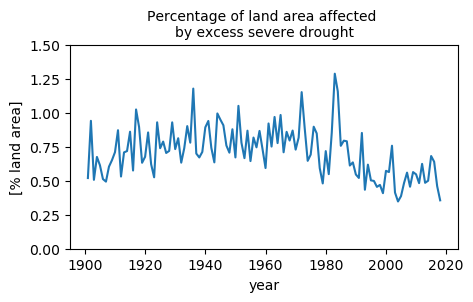

In [57]:
drought_area_ts = (drought_over_2std['N droughts'].sel(spi_months=6, drop=True, ) > 0).astype(int) * areas

drought_area_ts = (drought_area_ts
                   .sum(dim=['latitude', 'longitude'])
                   .to_dataframe(name='million km2')
                   .reset_index()
                   .set_index(['drought_severity', 'year'])['million km2']
                   .unstack().T
                  )
# Overkill categorical columns :P
drought_area_ts.columns = drought_area_ts.columns.astype(pd.CategoricalDtype(['MODERATE_DROUGHT','SEVERE_DROUGHT','EXTREME_DROUGHT'], ordered=True))
drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)['SEVERE_DROUGHT']

ax = (100*drought_area_ts / total_land_area.item()).plot()


ax.set(
    ylabel='[% land area]',
    title='Percentage of land area affected \nby excess severe drought',
    ylim=(0,1.5)
)
ax.figure.savefig(RESULTS_FOLDER / 'pct_area_excess_severe_drought.png')
ax.figure.show()

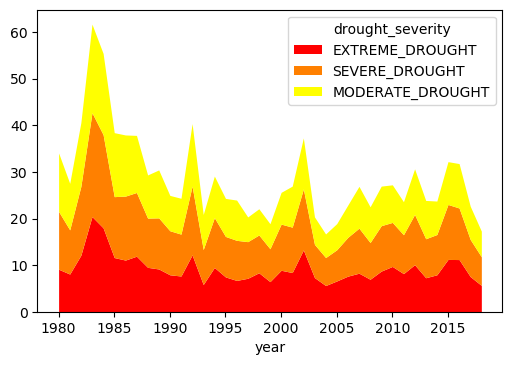

In [125]:
plot_drought_area(drought_over_2std.sel(year=slice(1980, None)), 6)

### SPI 3

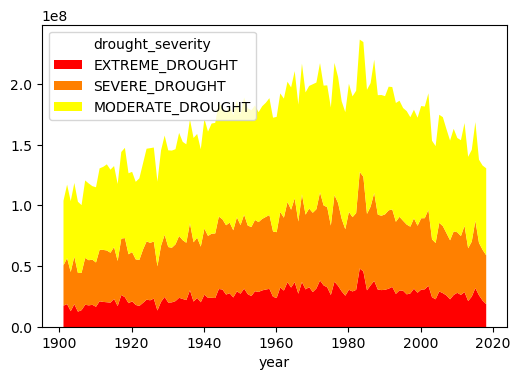

In [39]:
plot_drought_area(drought_counts, 3)

### SPI 6

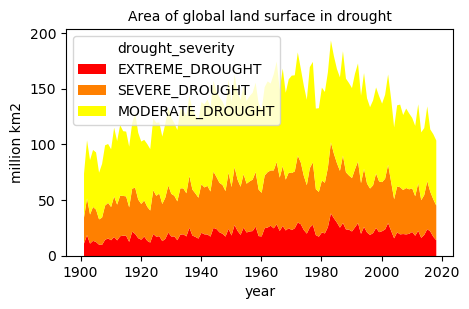

In [134]:
f, ax = plt.subplots(figsize=(5,3))
ax = plot_drought_area(drought_counts, 6, ax=ax)
ax.set(
    title='Area of global land surface in drought',
    ylabel='million km2'
)
ax.figure.savefig(RESULTS_FOLDER / 'area_in_drought.png')

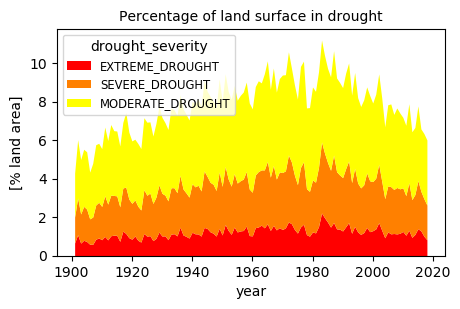

In [50]:
f, ax = plt.subplots(figsize=(5,3))
drought_area_ts = (drought_counts['N droughts'].sel(spi_months=6, drop=True) > 0).astype(int) * areas

drought_area_ts = (drought_area_ts
                   .sum(dim=['latitude', 'longitude'])
                   .to_dataframe(name='million km2')
                   .reset_index()
                   .set_index(['drought_severity', 'year'])['million km2']
                   .unstack().T
                  )
# Overkill categorical columns :P
drought_area_ts.columns = drought_area_ts.columns.astype(pd.CategoricalDtype(['MODERATE_DROUGHT','SEVERE_DROUGHT','EXTREME_DROUGHT'], ordered=True))
drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
ax = (100*drought_area_ts / total_land_area.item()).plot.area(linewidth=0, colormap='autumn', ax=ax)



ax.set(
    title='Percentage of land surface in drought',
    ylabel='[% land area]',
)
ax.figure.savefig(RESULTS_FOLDER / 'pct_area_in_drought.png')
ax.figure.show()


### SPI 12

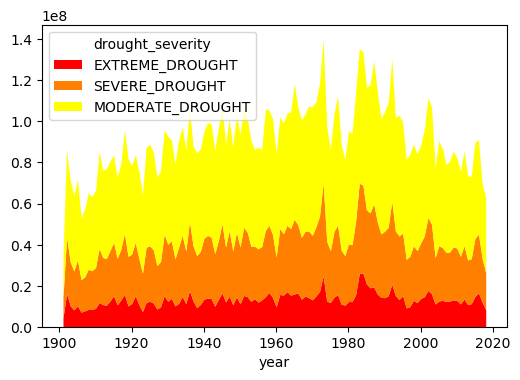

In [41]:
plot_drought_area(drought_counts, 12)